# Importing and cleaning

In [2]:
import pandas as pd
import graphviz 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sc
import statistics
from sklearn.model_selection import train_test_split
from sklearn import tree

In [3]:
df = pd.read_csv('AppleStore.csv', sep=',', header=0, index_col=0)

## Cleaning

Dropping the non relevant columns for our analysis. We don't care about the ID, the name of the app, its size, currency (they're all USD), current version, and whatever vpp_lic is (they're all == 1 anyway).

In [4]:
df = df.drop(['id','track_name', 'size_bytes', 'currency', 'ver', 'vpp_lic'], axis = 1)

Dropping the categorical variables.

In [5]:
df_nocat = df.drop(['cont_rating', 'prime_genre'], axis=1)

And storing them for later use.

In [6]:
df_cont = df[['cont_rating']]
df_gen = df[['prime_genre']]

Let's take a look at the data.

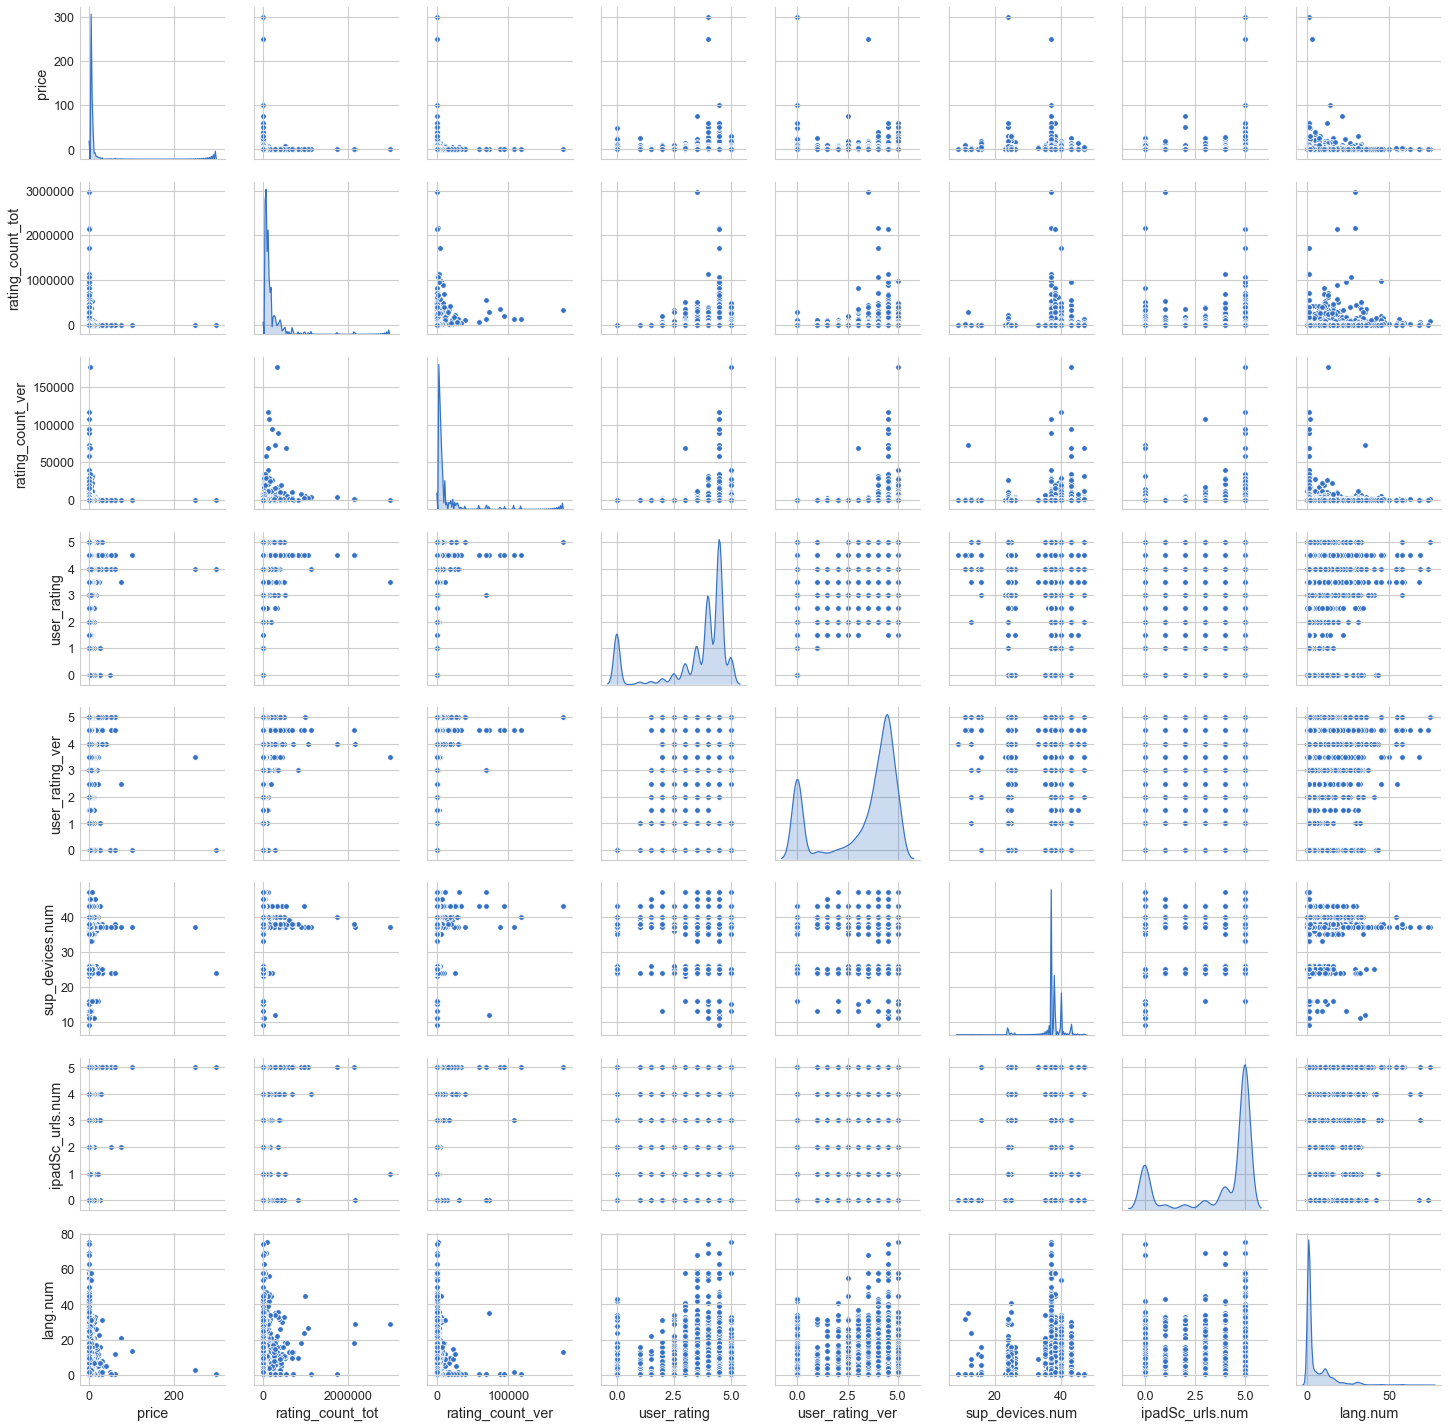

In [7]:
sns.pairplot(df_nocat, diag_kind='kde')

Not really representative or useful at the moment...

However, we can see from some univariate distributions that there are few outliers. We can remove them in order to prevent our following analyses from being somewhat skewed.

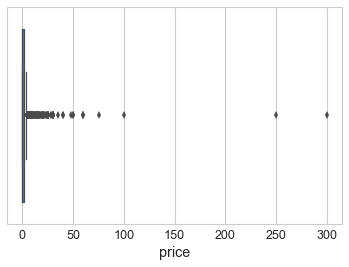

In [8]:
sns.boxplot(df_nocat['price'])

### Removing outliers

Let's normalize data and transform it in absolute value so that we can identify the outliers (value > 3), that is to say they're above the 3rd standard deviation.

In [9]:
z_score = np.abs(sc.zscore(df_nocat))
# normalizes data, returns absolute value

df_nocat = df_nocat.reset_index(drop=True)
# resets the index of df_nocat, start at 0

rem_row = np.unique(np.where(z_score > 3)[0])
# returns indexes of the rows that have at least
# one z_score > 3

df_nocat_noout = df_nocat.drop(rem_row, axis=0)
# removes rows that contain outliers,
# saves in new dataframe

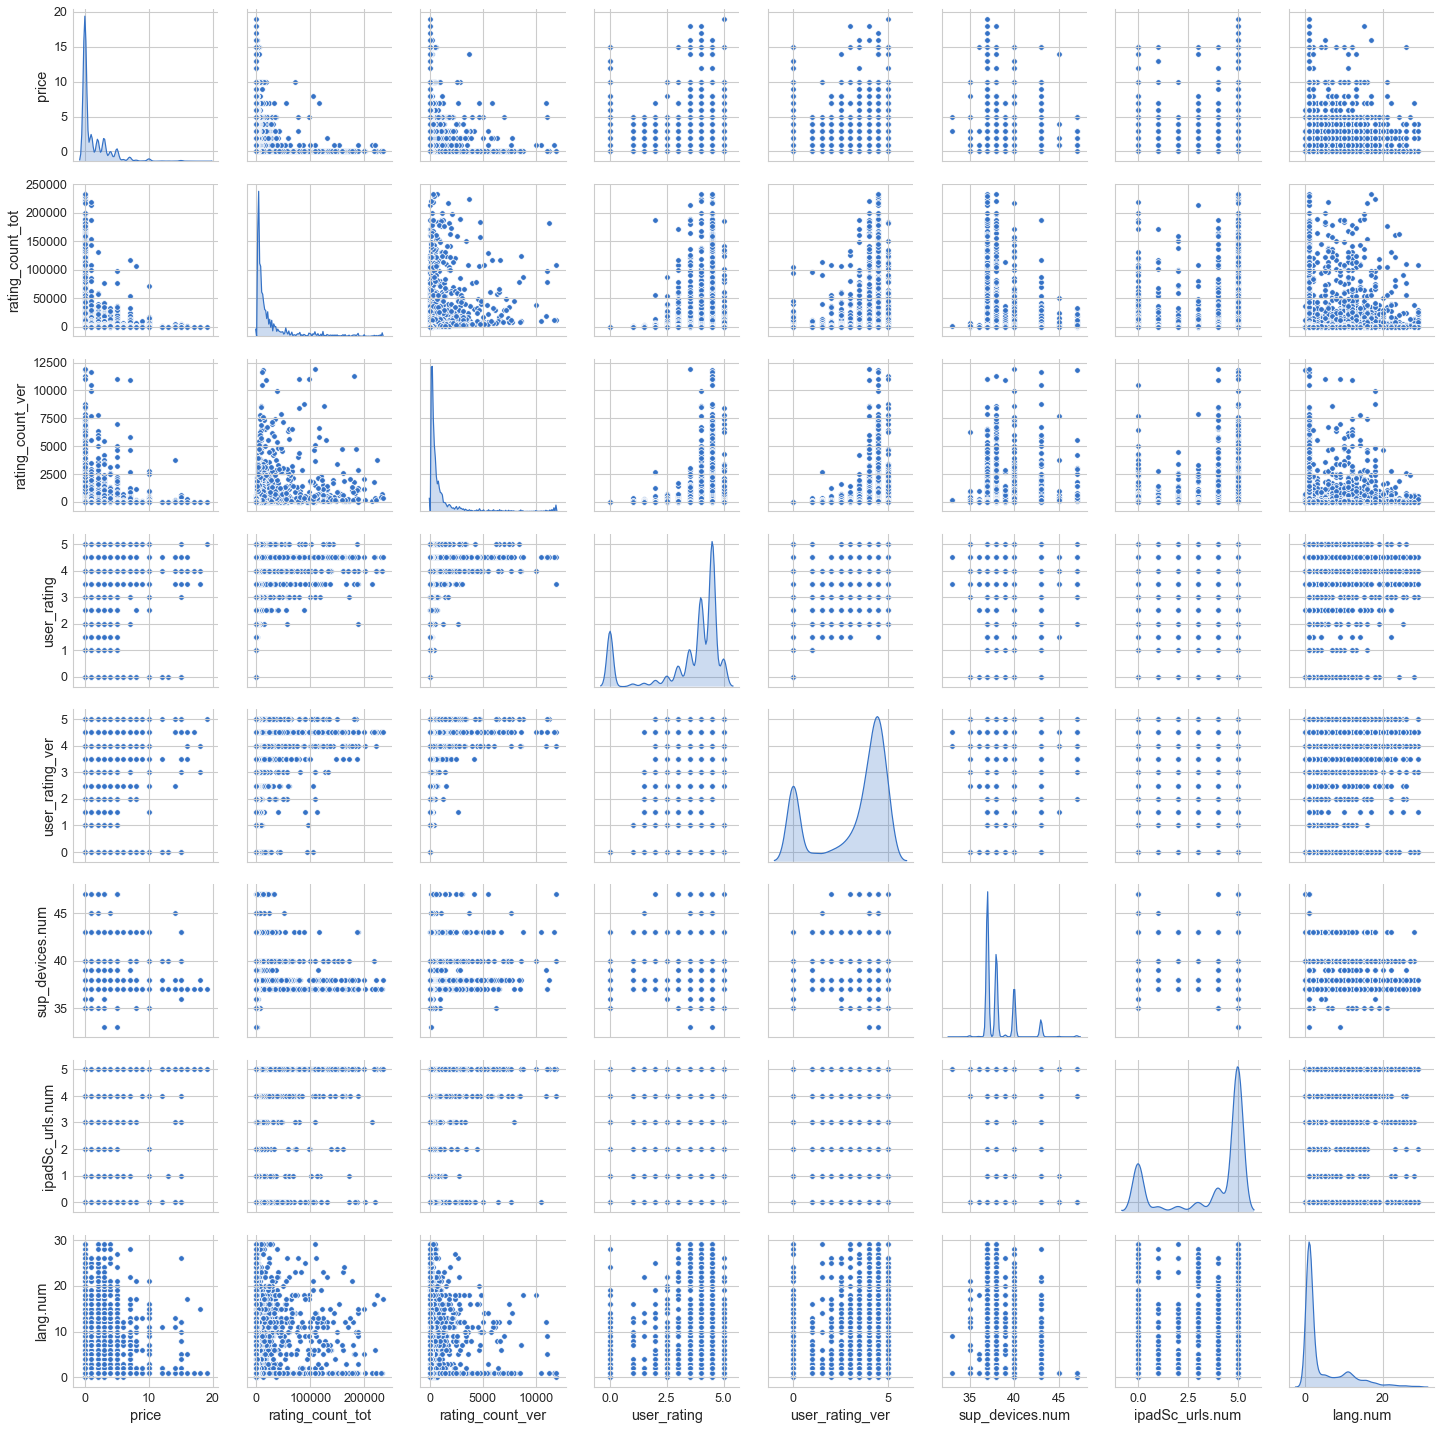

In [10]:
sns.pairplot(df_nocat_noout, diag_kind='kde')

A little better. Now at least univariate distribution of price is something more than a vertical line above the 0 value. Sure, the majority of apps are free, but the previous KDE was unreadable.

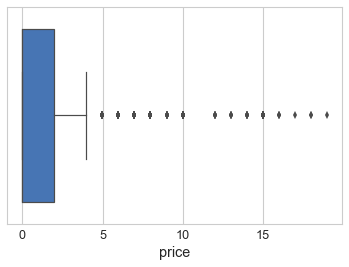

In [11]:
sns.boxplot(df_nocat_noout['price'])

# Starter analysis

## Correlation heatmap

Let's build a correlation heatmap to see if there is any relevant correlation between the variables.

In [12]:
corr = df_nocat_noout.corr()

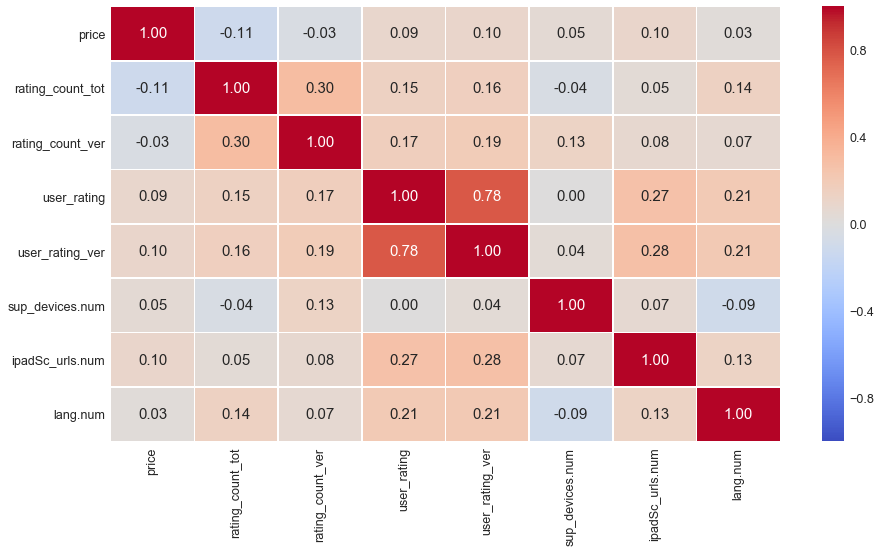

In [13]:
fig, ax = plt.subplots(figsize=(15,8))

hm = sns.heatmap(corr,
                 ax=ax,
                 cmap='coolwarm',
                 vmin=-1.0,
                 vmax=1.0,
                 annot=True,
                 fmt='.2f',
                 annot_kws={'size':15},
                 linewidths=0.5)

There's very low correlations between most attributes, looks like we need go further and use all the variables for our analysis.

Next we'll try to put user rating as "class", drop it from the DF, put back categorical variables, run a decision tree, see results, ????, profit.

## Decision tree

### Setup

We start by adding back the 2 categorical variables that we removed before, of course removing the rows that correspond to outlier data.

In [14]:
df_cont = df_cont.reset_index(drop=True)
df_gen = df_gen.reset_index(drop=True)
# resets the index of content rating and genre attributes, start at 0

df_cont = df_cont.drop(rem_row, axis=0)
df_gen = df_gen.drop(rem_row, axis=0)

# removes rows that contain outliers,
# saves in same dataframe

In [15]:
df_tree = pd.concat([df_nocat_noout, df_cont, df_gen], axis = 1)
#puts back the 2 attribute columns in the dataframe

In [16]:
df_tree['prime_genre'] = df_tree['prime_genre'].str.replace('&','and')
#replacs "&" with "and" because otherwise the decision tree graph goes bananas and produces
#2 billion errors.

We wanna to find out if _user rating_ is somewhat functionally dependent on a combination of other attributes, and to what degree. Let's group ratings arbitrarily, with this criteria:
- Last version rating > 3.5 : __Good__
- Last version rating ≥ 3.0 : __Okish__
- Last version rating < 3.0 : __Bad__

In [17]:
conditions = [
    (df_nocat_noout['user_rating_ver'] > 3.5),
    ((df_nocat_noout['user_rating_ver'] > 2.5) & (df_nocat_noout['user_rating_ver'] <= 3.5)),
    (df_nocat_noout['user_rating_ver'] < 3.0)]
choices = ['Good', 'Okish', 'Bad']

df_tree['Grade'] = np.select(conditions, choices, default=None)

Then we drop the user rating attributes from the DF.

In [18]:
df_tree = df_tree.drop(['user_rating_ver','user_rating'], axis=1)

Let's also drop rating count because otherwise the tree makes no sense.

In [19]:
df_tree = df_tree.drop(['rating_count_tot','rating_count_ver'], axis=1)

Assign the Grade column to a new DF.

In [20]:
df_grade = df_tree[['Grade']]

And drop it again from the original DF.

In [21]:
df_tree = df_tree.drop('Grade', axis=1)

There is an issue now. Sklearn decision tree does not handle categorical variables (such as _genre_). Only numerical ones. The second problem is that if we convert our categorical variables to numbers, the algorithm will think that they're ordinal, and therefore the higher the number the better, which in this case is obviously not only wrong, but also nonsensical.

We need to transform the categorical variables into __dummy__ ones.

### "Dummyfication" of categorical variables (one hot encoding)

In [22]:
one_hot_data = pd.get_dummies(df_tree, columns=['cont_rating','prime_genre'])

In [23]:
one_hot_data.head()

,price,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating_12+,cont_rating_17+,cont_rating_4+,cont_rating_9+,prime_genre_Book,prime_genre_Business,...,prime_genre_News,prime_genre_Photo and Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather
0,3.99,38,5,10,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.00,37,5,23,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.00,37,5,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0.99,47,5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.00,37,0,19,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_data, df_grade)
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 4854 samples in the training dataset
There are 1619 samples in the testing dataset
Each sample has 31 features


In [25]:
rnd_state = 666
clf = tree.DecisionTreeClassifier(criterion='entropy', random_state = rnd_state)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=666,
            splitter='best')

In [26]:
y_test = np.array(y_test)
y_train = np.array(y_train)
#transforms the dataframes into arrays so we can use them for comparison

In [27]:
y_predicted_train = clf.predict(X_train)
accuracy_train = np.mean(y_train == y_predicted_train)*100
print("The accuracy on training set is {0:.1f}%".format(accuracy_train))

The accuracy on training set is 49.0%


In [28]:
y_predicted_test = clf.predict(X_test)
accuracy_test = np.mean(y_test == y_predicted_test)*100
print("The accuracy on training set is {0:.1f}%".format(accuracy_test))

The accuracy on training set is 47.9%


The accuracy on this method is less than a coinflip, therefore useless. Also, the resulting decision tree is a nightmare. Need to do some further analysis.

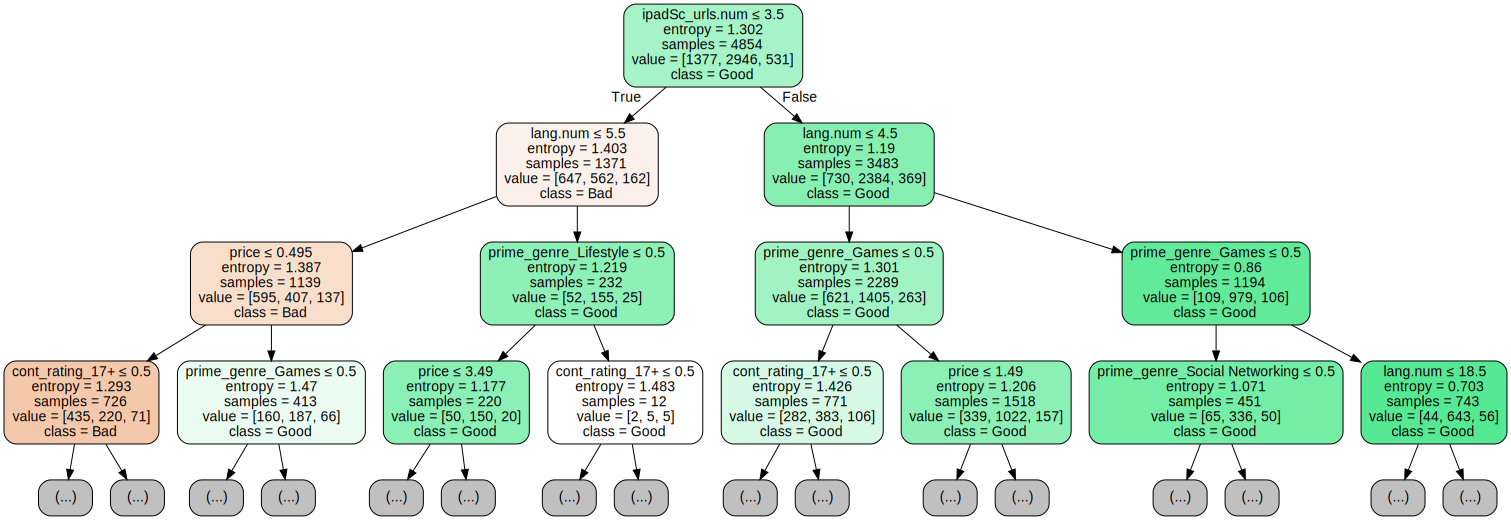

In [29]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=list(one_hot_data.keys()),
                                class_names=np.unique(df_grade),
                                filled=True, rounded=True,
                                special_characters=True,
                                max_depth= 3)  
graph = graphviz.Source(dot_data)  
graph